In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
df = pd.read_csv('car_data.csv');

In [29]:
# Logistic Regression
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict(X, theta):
    return sigmoid(np.dot(X, theta))

def predict_class(X, theta, threshold=0.5):
    probs = predict_prob(X, theta)
    return (probs >= threshold).astype(int)

def logistic_regression(X, y, learning_rate=0.01, epochs=1500):
    theta = np.zeros(X.shape[1])
    m = len(y)
    
    for epoch in range(epochs):
        h = predict_prob(X, theta)
        gradient = np.dot(X.T, (h - y)) / m
        theta -= learning_rate * gradient
    
    return theta

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [30]:
X = df[['Age', 'AnnualSalary']].values
y = df['Purchased'].values

# Add intercept term to X
X = np.c_[np.ones(X.shape[0]), X]

split_ratio = 0.8
split_index = int(split_ratio * X.shape[0])
X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]

# Training the model
theta = logistic_regression(X_train, y_train)

# Making predictions
pred = predict_class(X_test, theta)

# Calculate accuracy
acc = accuracy(y_test, pred)
print("Accuracy of Logistic Regression (without scaling):", acc)

Accuracy of Logistic Regression (without scaling): 0.395


C:\Users\shivam\AppData\Local\Temp\ipykernel_5084\3597654405.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


## 2 (b)

In [31]:
# Min-Max Scaling 
def min_max_scaling(data):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled = (data - min_val) / (max_val - min_val)
    return scaled

df['Age'] = min_max_scaling(df['Age'])
df['AnnualSalary'] = min_max_scaling(df['AnnualSalary'])

# features an target value
X_scaled = df[['Age', 'AnnualSalary']].values
X_scaled = np.c_[np.ones(X_scaled.shape[0]), X_scaled]

X_train_scaled = X_scaled[:split_index]
X_test_scaled = X_scaled[split_index:]

# Training the model with scaled data
theta = logistic_regression(X_train_scaled, y_train)

# Making predictions with scaled data
pred2 = predict_class(X_test_scaled, theta)

# Calculating accuracy with scaled data
acc2 = accuracy(y_test, pred2)
print("Accuracy of Logistic Regression (with scaling):", acc2)

Accuracy of Logistic Regression (with scaling): 0.71


## 2(c)

In [32]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

class KNN:
    def __init__(self, k=3):
        self.k = k
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)
    
    def _predict(self, x):
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        ans = np.bincount(k_nearest_labels).argmax()
        return ans

# KNN
knn = KNN(k=5)

# scale
knn.fit(X_train_scaled[:, 1:], y_train)

# Predictions using KNN
knn_predictions = knn.predict(X_test_scaled[:, 1:]) 

# Calculate accuracy of KNN
knn_acc = accuracy(y_test, knn_predictions)
print("Accuracy of KNN:", knn_acc)


Accuracy of KNN: 0.91


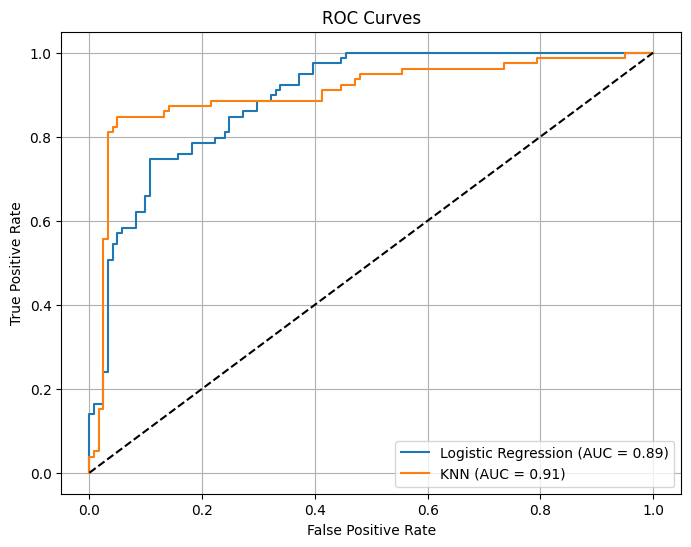

AUC Score - Logistic Regression: 0.8928758238309447
AUC Score - KNN: 0.9053248247724672


In [39]:
def roc_curve(y_true, y_scores):
    # Combine true labels and predicted scores
    combined = list(zip(y_scores, y_true))

    # Sort the combined list by predicted scores
    sorted_combined = sorted(combined, key=lambda x: x[0], reverse=True)

    # Separate sorted labels and scores
    sorted_labels = [x[1] for x in sorted_combined]
    sorted_scores = [x[0] for x in sorted_combined]

    tpr_points = [0]  # True Positive Rate
    fpr_points = [0]  # False Positive Rate
    auc = 0

    # Count true positives and false positives
    P = sum(y_true)
    N = len(y_true) - P

    tp_count = 0  # Count of true positives
    fp_count = 0  # Count of false positives

    for i in range(len(sorted_labels)):
        if sorted_labels[i] == 1:
            tp_count += 1
        else:
            fp_count += 1

        tpr = tp_count / P
        fpr = fp_count / N

        tpr_points.append(tpr)
        fpr_points.append(fpr)

        # Calculate trapezoidal area under curve
        auc += 0.5 * (fpr_points[-1] - fpr_points[-2]) * (tpr_points[-1] + tpr_points[-2])

    return fpr_points, tpr_points, auc



# Logistic Regression Predictions
lr_probabilities = predict(X_test_scaled, theta)
lr_fpr, lr_tpr, lr_auc = roc_curve(y_test, lr_probabilities)

# KNN Predictions
knn_probabilities = [1 if p == 1 else 0 for p in knn_predictions]  # Convert 1/0 to probabilities
knn_fpr, knn_tpr, knn_auc = roc_curve(y_test, knn_probabilities)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label=f"Logistic Regression (AUC = {lr_auc:.2f})")
plt.plot(knn_fpr, knn_tpr, label=f"KNN (AUC = {knn_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

print("AUC Score - Logistic Regression:", lr_auc)
print("AUC Score - KNN:", knn_auc)
